In [14]:
import torch
import torchvision
import torch.nn as nn
from torchvision import models
from torchsummary import summary
import numpy as np
import os
from PIL import Image


model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

In [15]:
from torchvision import transforms

imgPaths = r"C:\Users\zanyi\Documents\GitHub\YIC2025\segmentationTest\images"

t = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor()
])

loaded_images = []
for imgPath in os.listdir(imgPaths):
    print(os.path.join(imgPaths,imgPath))
    loaded_images.append(t(Image.open(os.path.join(imgPaths, imgPath))))
    
print(loaded_images[0].shape)


C:\Users\zanyi\Documents\GitHub\YIC2025\segmentationTest\images\plankton-1.jpg
C:\Users\zanyi\Documents\GitHub\YIC2025\segmentationTest\images\plankton2.jpg
torch.Size([3, 520, 520])


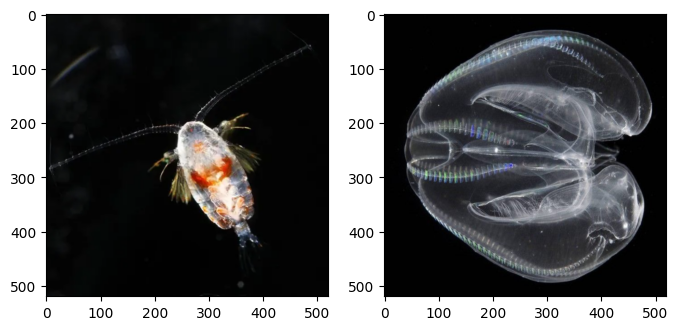

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8)) # Example for a 2x2 grid
axes[1].imshow(loaded_images[0].permute(1,2,0).numpy())
axes[0].imshow(loaded_images[1].permute(1,2,0).numpy())

plt.show()
    

In [17]:
test = loaded_images[0]

print(summary(model=model.to("cuda"), input_size=loaded_images[0].shape)) #remember to put model on cuda/give the selected model a platform to perform on.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 260, 260]             864
       BatchNorm2d-2         [-1, 32, 260, 260]              64
              SiLU-3         [-1, 32, 260, 260]               0
            Conv2d-4         [-1, 32, 260, 260]             288
       BatchNorm2d-5         [-1, 32, 260, 260]              64
              SiLU-6         [-1, 32, 260, 260]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 260, 260]               0
           Conv2d-13         [-1, 16, 260, 260]             512
      BatchNorm2d-14         [-1, 16, 2

In [ ]:
model.eval()

image1 = loaded_images[0].to("cuda").to(torch.float32).unsqueeze(0)
print(image1.shape)
image2 = loaded_images[1].to("cuda").to(torch.float32).unsqueeze(0)
print(image2.shape)

embeddings = []
with torch.no_grad():
    features = model.features(image1)
    embedding = torch.flatten(model.avgpool(features))
    embeddings.append(embedding.cpu().numpy())
    
    features = model.features(image2)
    embedding = torch.flatten(model.avgpool(features))
    embeddings.append(embedding.cpu().numpy())

embeddings = np.stack(embeddings)
# print(features.shape)
print(embeddings.shape)

torch.Size([1, 3, 520, 520])
torch.Size([1, 3, 520, 520])
(2, 1280)


In [ ]:
from sklearn.manifold import TSNE

embeddings_np = embeddings
print(embeddings_np.shape)
reduced_embeddings = TSNE(n_components=2,perplexity=1).fit_transform(embeddings_np)
reduced_embeddings.shape

(2, 1280)


(2, 2)

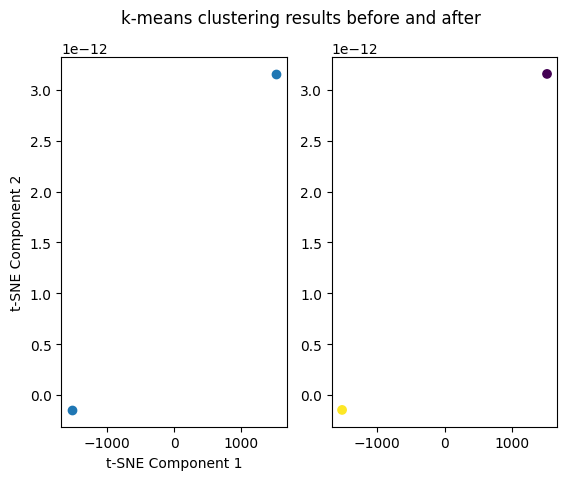

In [ ]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit_transform(reduced_embeddings)

fig,ax = plt.subplots(ncols=2,nrows=1)
fig.suptitle("k-means clustering results before and after")

ax[0].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")

ax[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)

plt.show()


we can automatically select the k-means via sillouette method
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.561464362648773
For n_clusters = 6 The average silhouette_score is : 0.4857596147013469


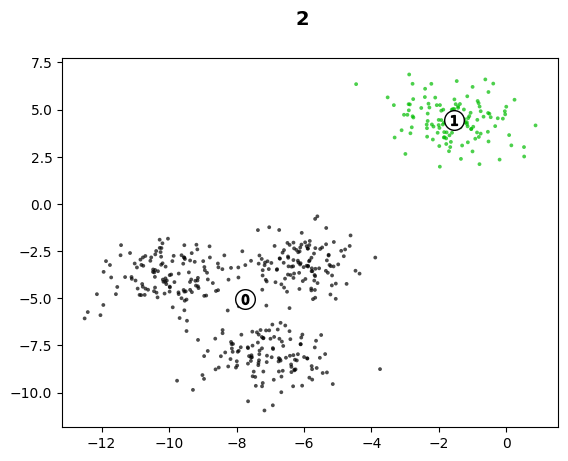

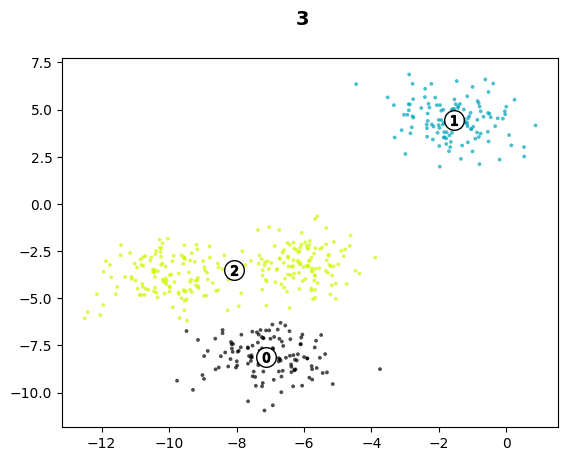

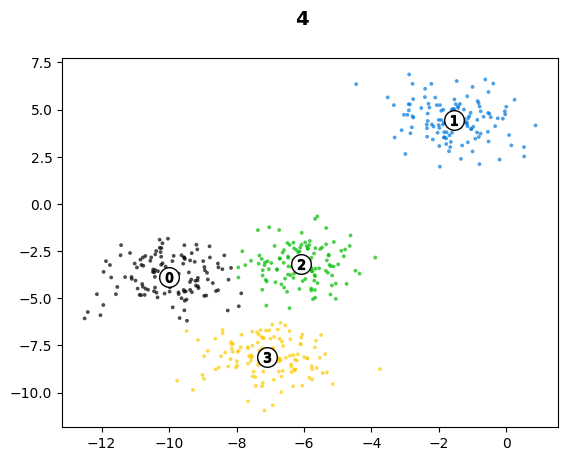

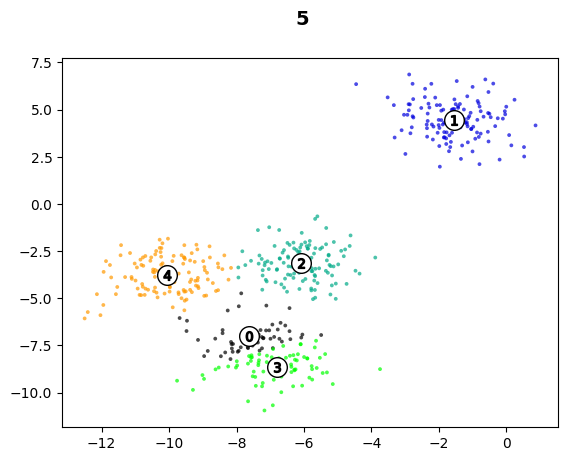

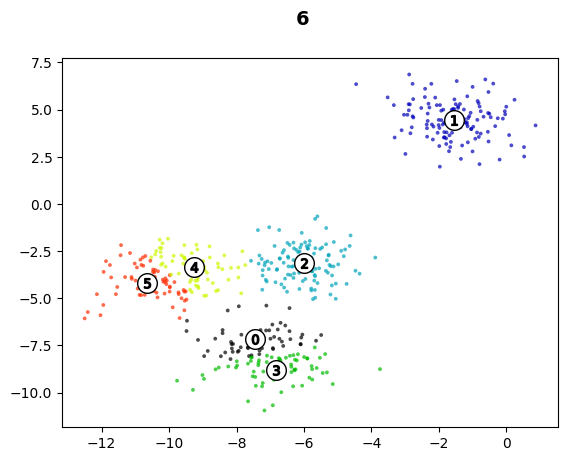

best cluster is when k=2 with score of 0.7050


In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]
bestK = 0
runningSilhouetteAvg=0

for n_clusters in range_n_clusters:
    fig, ax2 = plt.subplots()

    # Initialize the clusterer with n_clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    if silhouette_avg>runningSilhouetteAvg:
        runningSilhouetteAvg=silhouette_avg
        bestK=n_clusters

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    plt.suptitle(
        n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

print(f"best cluster is when k={bestK} with score of {runningSilhouetteAvg:.4f}")